In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [2]:
y = np.random.randint(0,7,2100)
idx= []
for i in range(7):
    print(i,sum(y==i))
    idx.append(y==i)

0 292
1 311
2 283
3 309
4 304
5 290
6 311


In [3]:
x = np.zeros((2100,2))

In [4]:


x[idx[0],:] = np.random.uniform(low=[1,8],high=[2,7],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[1,5],high=[2,6],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[1,3],high=[2,4],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1,1],high=[2,2],size=(sum(idx[3]),2))

x[idx[4],:] = np.random.uniform(low=[1,-1],high=[2,0],size=(sum(idx[4]),2))

x[idx[5],:] = np.random.uniform(low=[1,-2],high=[2,-3],size=(sum(idx[5]),2))


x[idx[6],:] = np.random.uniform(low=[2.2,0],high=[3.2,3],size=(sum(idx[6]),2))


#x[idx[7],:] = np.random.uniform(low=[2.5,1],high=[3.5,4],size=(sum(idx[7]),2))


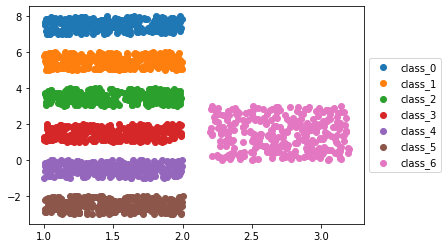

In [5]:
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("dist_4.png",bbox_inches="tight")
plt.savefig("dist_4.pdf",bbox_inches="tight")


In [6]:
foreground_classes = {'class_0','class_1'}

background_classes = {'class_2'}

In [7]:
fg_class  = np.random.randint(0,6)
fg_idx = np.random.randint(0,9) #m=2

a = []

for i in range(9): #m=2
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(6,7)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 6 present at 0
background 6 present at 1
foreground 1 present at 2
background 6 present at 3
background 6 present at 4
background 6 present at 5
background 6 present at 6
background 6 present at 7
background 6 present at 8
(9, 2)
1 2


In [8]:
a.shape

(9, 2)

In [9]:
np.reshape(a,(18,1))

array([[3.00905263],
       [0.34373455],
       [2.72833097],
       [1.5384064 ],
       [1.23724301],
       [5.02553474],
       [2.28769939],
       [0.01033115],
       [3.00905263],
       [0.34373455],
       [2.99064336],
       [0.09937262],
       [2.88047089],
       [1.44119993],
       [2.95451049],
       [1.01705006],
       [2.43737177],
       [1.83476779]])

In [10]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9) #m=2
    a = []
    np.random.seed(i+j)
    for i in range(9):  #m=2
        if i == fg_idx: 
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(18,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [11]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [12]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(3000,)
(3000,)


In [13]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [14]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,1)
        #self.linear2 = nn.Linear(100,200)
        #self.linear3 = nn.Linear(200,1)

    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)  #m=2
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):  #m=9
          x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9): #m=9
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

    

In [15]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [16]:
torch.manual_seed(1240)
where = Wherenet().double()
where = where
out_where,alphas = where(input1)
out_where.shape,alphas.shape

(torch.Size([250, 2]), torch.Size([250, 9]))

In [17]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,800)
        self.linear2 = nn.Linear(800,6)
        #self.linear3 = nn.Linear(10,15)
        #self.linear4 = nn.Linear(15,20)
        #self.linear5 = nn.Linear(20,25)
        #self.linear6 = nn.Linear(25,6)
    
    def forward(self,x):
      x = F.relu(self.linear1(x))
      #x = F.relu(self.linear2(x))
      #x = F.relu(self.linear3(x))
      #x = F.relu(self.linear4(x))
      #x = F.relu(self.linear5(x))
      x = self.linear2(x)
      return x

In [18]:
torch.manual_seed(1234)
what = Whatnet().double()
# what(out_where)

In [19]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9)  #m=2
    a = []
    for i in range(9): #m=2
        np.random.seed(i+j+3000)
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(18,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [20]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
print(mosaic_list_test.shape)

(1000, 18)


In [21]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [22]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [23]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    avg_inp,alphas = where(inputs)
    outputs = what(avg_inp)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 30000 train images: 16 %
total correct 499
total train set images 3000
focus_true_pred_true 0 =============> FTPT : 0 %
focus_false_pred_true 499 =============> FFPT : 16 %
focus_true_pred_false 1068 =============> FTPF : 35 %
focus_false_pred_false 1433 =============> FFPF : 47 %
argmax_more_than_half ==================>  254
argmax_less_than_half ==================>  2746
3000


In [24]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    avg_inp,alphas = where(inputs)    
    outputs = what(avg_inp)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 10000 test images: 17 %
total correct 178
total train set images 1000
focus_true_pred_true 0 =============> FTPT : 0 %
focus_false_pred_true 178 =============> FFPT : 17 %
focus_true_pred_false 343 =============> FTPF : 34 %
focus_false_pred_false 479 =============> FFPF : 47 %
argmax_more_than_half ==================>  90
argmax_less_than_half ==================>  910


In [25]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


criterion = nn.CrossEntropyLoss()
optimizer_where = optim.Adam(where.parameters(), lr=0.01)#,momentum=0.9)
optimizer_what = optim.Adam(what.parameters(), lr=0.01)#, momentum=0.9)

nos_epochs = 200
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


[1,     6] loss: 2.858
[1,    12] loss: 1.490
[2,     6] loss: 1.144
[2,    12] loss: 0.979
[3,     6] loss: 0.894
[3,    12] loss: 0.834
[4,     6] loss: 0.802
[4,    12] loss: 0.812
[5,     6] loss: 0.795
[5,    12] loss: 0.786
[6,     6] loss: 0.788
[6,    12] loss: 0.729
[7,     6] loss: 0.728
[7,    12] loss: 0.685
[8,     6] loss: 0.687
[8,    12] loss: 0.689
[9,     6] loss: 0.640
[9,    12] loss: 0.667
[10,     6] loss: 0.666
[10,    12] loss: 0.617
[11,     6] loss: 0.613
[11,    12] loss: 0.636
[12,     6] loss: 0.622
[12,    12] loss: 0.596
[13,     6] loss: 0.585
[13,    12] loss: 0.586
[14,     6] loss: 0.590
[14,    12] loss: 0.576
[15,     6] loss: 0.562
[15,    12] loss: 0.578
[16,     6] loss: 0.568
[16,    12] loss: 0.559
[17,     6] loss: 0.576
[17,    12] loss: 0.565
[18,     6] loss: 0.538
[18,    12] loss: 0.555
[19,     6] loss: 0.547
[19,    12] loss: 0.529
[20,     6] loss: 0.530
[20,    12] loss: 0.522
[21,     6] loss: 0.536
[21,    12] loss: 0.525
[22,     6

In [26]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [27]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,254,2746,0,499,1068,1433
1,4,588,2412,1228,643,69,1060
2,9,997,2003,1467,528,48,957
3,14,1061,1939,1489,632,36,843
4,19,1161,1839,1518,690,45,747
5,24,1300,1700,1633,664,53,650
6,29,1419,1581,1724,568,69,639
7,34,1486,1514,1804,635,89,472
8,39,1563,1437,1875,622,90,413
9,44,1652,1348,1933,599,104,364


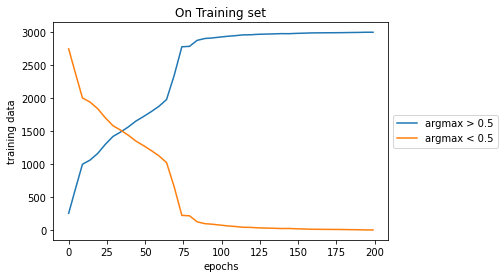

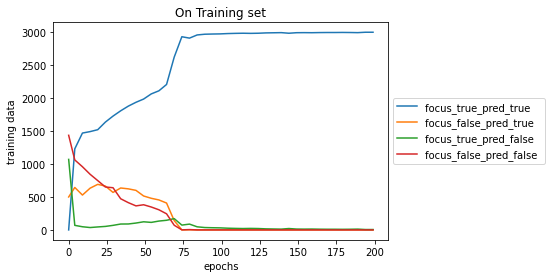

In [28]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.savefig("dist_4_train.png",bbox_inches="tight")
plt.savefig("dist_4_train.pdf",bbox_inches="tight")
plt.show()

In [29]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,90,910,0,178,343,479
1,4,211,789,411,211,27,351
2,9,321,679,478,171,10,341
3,14,339,661,480,219,11,290
4,19,373,627,488,219,21,272
5,24,420,580,531,197,16,256
6,29,451,549,583,203,9,205
7,34,471,529,602,183,25,190
8,39,500,500,603,203,44,150
9,44,530,470,642,182,24,152


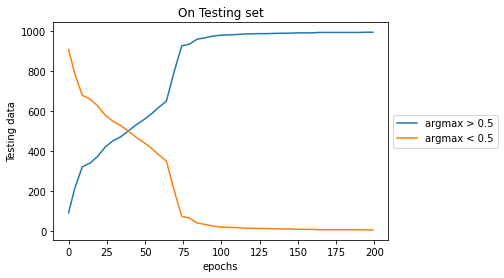

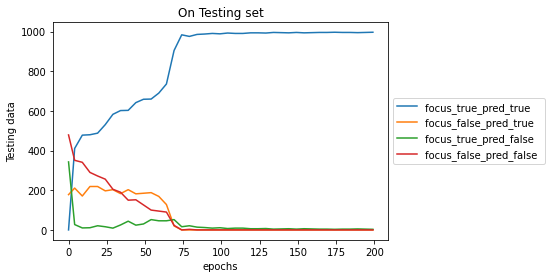

In [30]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.savefig("dist_4_test.png",bbox_inches="tight")
plt.savefig("dist_4_test.pdf",bbox_inches="tight")
plt.show()

In [31]:
# where.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 0, -1]]))
# where.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0]))

In [32]:
for param in where.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[-5.3328,  0.0948]], dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([0.2049], dtype=torch.float64, requires_grad=True))


In [33]:
# what.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 5,  0],
#         [0,5],
#         [ 0, 0]]))
# what.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0,  0, 0]))

In [34]:
# for param in what.named_parameters():
#   print(param)

In [35]:
xx,yy= np.meshgrid(np.arange(0.5,6,0.05),np.arange(-3.5,8.5,0.05))
X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
X = torch.Tensor(X).double()
Y = where.helper(X)
Y1 = what(X)

In [36]:
X.shape,Y.shape

(torch.Size([26400, 2]), torch.Size([26400, 1]))

In [37]:
X = X.detach().numpy()
Y = Y[:,0].detach().numpy()

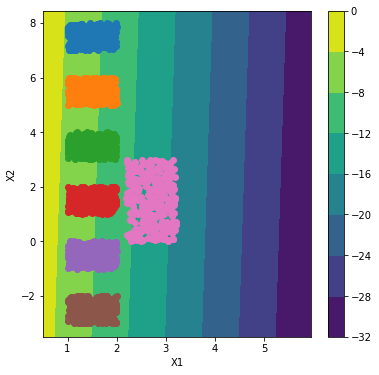

In [38]:
fig = plt.figure(figsize=(6,6))
cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Y.reshape(xx.shape))
plt.xlabel("X1")
plt.ylabel("X2")
fig.colorbar(cs)
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("dist_4_fc.png")#,bbox_inches='tight')
plt.savefig("dist_4_fc.pdf")

In [39]:
Y1 = Y1.detach().numpy()
Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
_,Z4= torch.max(Y1,1)
Z1 = Y1[:,0]
Z2 = Y1[:,1]
#Z3 = Y1[:,2]

In [40]:
np.unique(Z4)

array([0, 1, 2, 3, 4, 5])

In [41]:
#fig = plt.figure(figsize=(6,6))
# plt.scatter(X[:,0],X[:,1],c=Z1)
# plt.scatter(X[:,0],X[:,1],c=Z2)
# plt.scatter(X[:,0],X[:,1],c=Z3)
#cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z1.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z2.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z3.reshape(xx.shape))
#plt.colorbar(cs)
# plt.xlabel("X1")
# plt.ylabel("X2")
#ax.view_init(60,100)
#plt.savefig("non_interpretable_class_2d.pdf",bbox_inches='tight')


In [42]:
avrg = []
lbl = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          avg_inp,alphas = where(inputs)
          avrg.append(avg_inp)
          lbl.append(labels.numpy())
avrg= np.concatenate(avrg,axis=0)
lbl = np.concatenate(lbl,axis=0)

In [43]:
indices = []
for i in range(6):
    print(i,sum(lbl==i))
    indices.append(lbl==i)

0 533
1 481
2 497
3 482
4 508
5 499


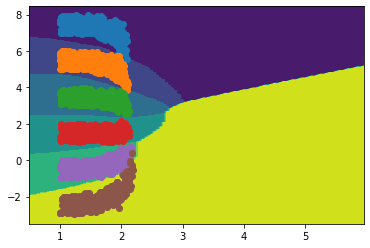

In [44]:
cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z4.reshape(xx.shape))
for i in range(6):
    plt.scatter(avrg[indices[i],0],avrg[indices[i],1],label="class_"+str(i))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.scatter(avrg[:,0],avrg[:,1],c="c")
plt.savefig("dist_4_db.png",bbox_inches="tight")
plt.savefig("dist_4_db.pdf",bbox_inches="tight")

In [45]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [46]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[532,   1,   0,   0,   0,   0],
       [  0, 481,   0,   0,   0,   0],
       [  0,   0, 497,   0,   0,   0],
       [  0,   0,   0, 482,   0,   0],
       [  0,   0,   0,   0, 506,   2],
       [  0,   0,   0,   0,   3, 496]])

In [48]:
sum(true==pred)/3000

0.998